In [1]:
from pathlib import Path
from ase.io import read, write
import ovito
import numpy as np
import pandas as pd
#from counter import cus_site, bridge_site
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 20}
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **font)

In [2]:
sim_index = 0
path = Path(f"/work/surf/iter3/bigB_sims/random_comps/sim_{sim_index}")
md = read(path/'newmd.xyz', ":")
init_struc = read(path/'mix.xyz')

INIT STRUC

In [3]:
from ovito.vis import DataVis
from ovito.pipeline import Pipeline, StaticSource
from ovito.io.ase import ase_to_ovito
from ovito.vis import Viewport
ovi_data = ase_to_ovito(init_struc)
pipeline = Pipeline(source = StaticSource(data = ovi_data))
pipeline.add_to_scene()
vp = Viewport(type = Viewport.Type.Ortho, camera_dir = (1, 0, 0))
vp.zoom_all()
display(vp)

JupyterViewportWidget(camera_params={'fov': 39.497759400472276, 'perspective': False, 'matrix': [[0.0, -0.0, -…

In [4]:
atoms = init_struc
max_Ir_Z = max([atom.z for atom in atoms if atom.symbol == 'Ir'])
#These Iridiums are expected to stay put
Ir_bri = np.array([atom.index for atom in atoms if (atom.symbol == 'Ir') and (atom.z == max_Ir_Z)])
Ir_cus = np.array([atom.index for atom in atoms if (atom.symbol == 'Ir' and (np.round(max_Ir_Z - atom.z, 4) == 0.0953) and atom.index not in Ir_bri)])

#Everything else can be dynamic and is counted in a general way
O_cus = np.array([atom.index for atom in atoms if (atom.symbol == 'O' and atom.z > max_Ir_Z and min(atoms.get_distances(atom.index, Ir_cus, mic=True))<2.3 and min(atoms.get_distances(atom.index, Ir_bri, mic=True))>2.3)])

In [5]:
from composition import count_bridge, count_cus
bri_df, cus_df = [], []
for atoms in md[::100]:
    time, O_bri, bri_O_H2, bri_O_H, bri_O_c =  count_bridge(atoms, Ir_bri=Ir_bri, Ir_cus=Ir_cus, max_Ir_Z=max_Ir_Z)
    append_this_bri = pd.DataFrame([{'Time': time, 'OH2': len(bri_O_H2), 'OH': len(bri_O_H), 'O': len(bri_O_c), 'All': len(O_bri)}])
    bri_df.append(append_this_bri)
    time, O_cus, cus_O_H2, cus_O_H, cus_O_c, cus_O_O =  count_cus(atoms, Ir_bri=Ir_bri, Ir_cus=Ir_cus, max_Ir_Z=max_Ir_Z)
    append_this_cus = pd.DataFrame([{'Time': time, 'OH2': len(cus_O_H2), 'OH': len(cus_O_H), 'O': len(cus_O_c), 'OO': len(cus_O_O), 'All': len(O_cus)}])
    cus_df.append(append_this_cus)
bri_df = pd.concat(bri_df)
cus_df = pd.concat(cus_df)

,Time,OH2,OH,O,OO,All
0,0.0,7,3,5,9,24
0,10.0,9,5,1,9,24
0,20.0,9,5,1,9,24
0,30.0,10,4,2,8,24
0,40.0,8,6,2,8,24
0,50.0,11,3,2,8,24
0,60.0,11,3,2,8,24
0,70.0,10,4,2,8,24
0,80.0,12,2,2,8,24
0,90.0,12,2,2,8,24


JOINT PLOTS

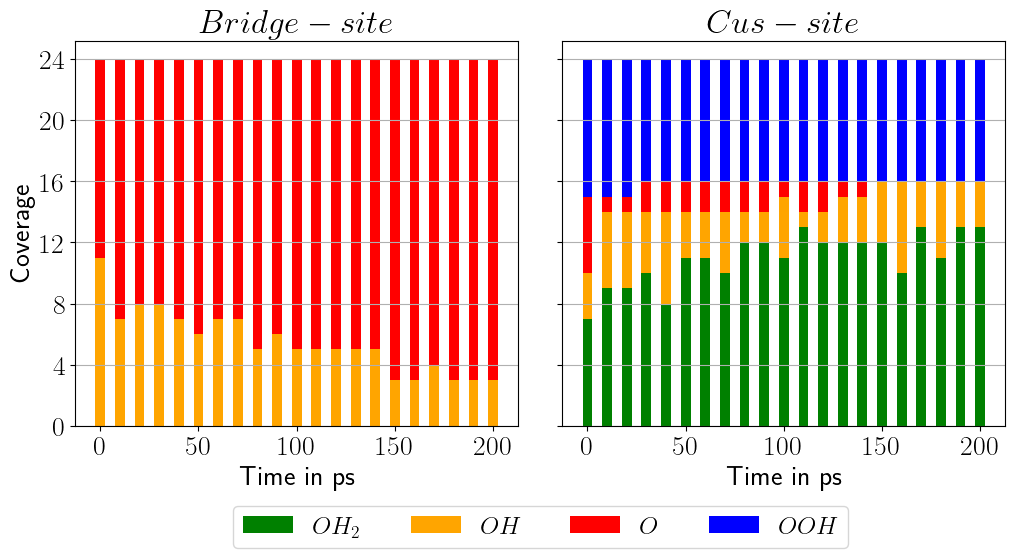

In [56]:
bar_width = 5.0
fig = plt.figure()
fig.set_size_inches(12,5)
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.1)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')

ax1.bar(bri_df['Time'], bri_df['OH'],  width=bar_width, label = '$OH$', bottom=bri_df['OH2'], color = 'orange')
ax1.bar(bri_df['Time'], bri_df['O'],   width=bar_width, label = '$O$', bottom=bri_df['OH2'] + bri_df['OH'], color = 'red')
ax1.set_title(f"$Bridge-site$")
ax2.bar(cus_df['Time'], cus_df['OH2'], width=bar_width, label = '$OH_{2}$', color = 'green')
ax2.bar(cus_df['Time'], cus_df['OH'],  width=bar_width, label = '$OH$', bottom=cus_df['OH2'], color = 'orange')
ax2.bar(cus_df['Time'], cus_df['O'],   width=bar_width, label = '$O$',  bottom=cus_df['OH2'] + cus_df['OH'], color = 'red')
ax2.bar(cus_df['Time'], cus_df['OO'],  width=bar_width, label = '$OOH$', bottom=cus_df['OH2'] + cus_df['OH'] + cus_df['O'], color = 'blue')
ax2.set_title(f"$Cus-site$")

for ax in [ax1,ax2]:
    ax.set_yticks(range(0,25,4))
    ax.grid(axis='y')
    ax.set(xlabel='Time in ps', ylabel=f"Coverage{chr(37)}")
    ax.label_outer()
leg = plt.legend(loc='lower center',prop={'size': 18}, bbox_to_anchor=(-0.05,-0.35), ncol=4)
leg._legend_box.align = "left"
#plt.savefig(f"./bri_bar_{sim_index}.png", dpi=300, bbox_inches='tight')

Individual plot

In [6]:
plot_bars  = True
plot_lines = False
bar_width = 5.0
fig = matplotlib.pyplot.gcf()

<Figure size 640x480 with 0 Axes>

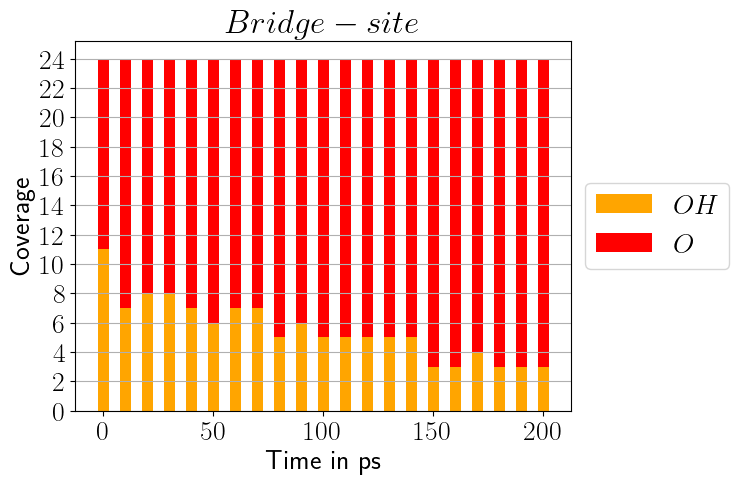

In [9]:
if plot_lines:
    #plt.plot(bri_df['Time'], bri_df['OH2'], label = '$OH_{2}$', color = 'green',  ls='--', alpha=0.5)#, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="pink")
    plt.plot(bri_df['Time'], bri_df['OH'], label = '$OH$',      color = 'orange', ls='--', alpha=1.0, linewidth=2.0)#, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="red")
    plt.plot(bri_df['Time'], bri_df['O'],  label = '$O$',       color = 'red',    ls='--', alpha=0.5)#,marker="o", markersize=10, markeredgecolor="black", markerfacecolor="violet")

if plot_bars:
    #plt.bar(bri_df['Time'], bri_df['OH2'], width=bar_width, label = '$OH_{2}$', color = 'green')#, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="pink")
    plt.bar(bri_df['Time'], bri_df['OH'],  width=bar_width, label = '$OH$', bottom=bri_df['OH2'], color = 'orange')#, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="red")
    plt.bar(bri_df['Time'], bri_df['O'],   width=bar_width, label = '$O$', bottom=bri_df['OH2'] + bri_df['OH'], color = 'red')#,marker="o", markersize=10, markeredgecolor="black", markerfacecolor="violet")

plt.yticks(range(0,26,2))
plt.grid(axis='y')
plt.xlabel("Time in ps")
plt.ylabel(f"Coverage{chr(37)}")
plt.title(f"$Bridge-site$")
leg = plt.legend(loc='center left', prop={'size': 20}, bbox_to_anchor=(1, 0.5) )
leg._legend_box.align = "left"
if plot_bars:
    plt.savefig(f"./bri_bar_{sim_index}.png", dpi=300, bbox_inches='tight')
if plot_lines:
    plt.savefig(f"./bri_lines_{sim_index}.png", dpi=300, bbox_inches='tight')

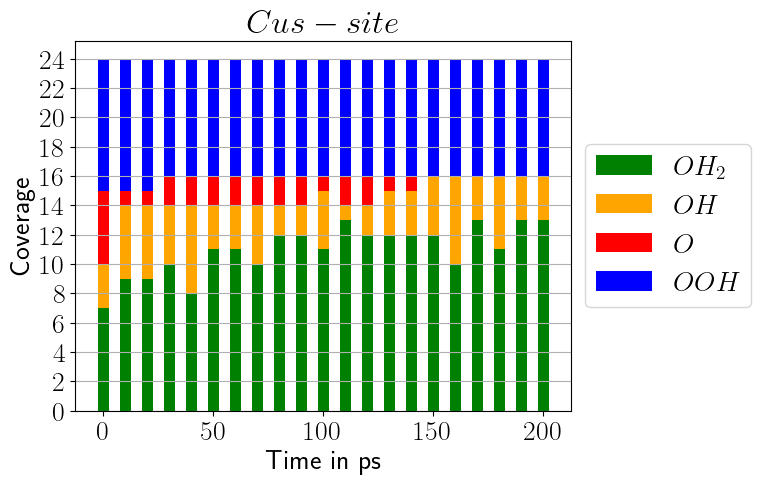

In [13]:
if plot_lines:
    plt.plot(cus_df['Time'], cus_df['OH2'],label = '$OH_{2}$', color = 'green',  ls='--', linewidth=1.5, alpha=0.5)#, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="pink")
    plt.plot(cus_df['Time'], cus_df['OH'], label = '$OH$',     color = 'orange', ls='--', alpha=1.0)#, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="red")
    plt.plot(cus_df['Time'], cus_df['O'],  label = '$O$',      color = 'red',    ls='--', linewidth=1.5, alpha=0.5)#,marker="o", markersize=10, markeredgecolor="black", markerfacecolor="violet")
    plt.plot(cus_df['Time'], cus_df['OO'], label = '$OO$',     color = 'blue',   ls="--", alpha=0.5)#,marker="o", markersize=10, markeredgecolor="black", markerfacecolor="violet")
if plot_bars:
    plt.bar(cus_df['Time'], cus_df['OH2'], width=bar_width, label = '$OH_{2}$', color = 'green')#, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="pink")
    plt.bar(cus_df['Time'], cus_df['OH'],  width=bar_width, label = '$OH$', bottom=cus_df['OH2'], color = 'orange')#, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="red")
    plt.bar(cus_df['Time'], cus_df['O'],   width=bar_width, label = '$O$',  bottom=cus_df['OH2'] + cus_df['OH'], color = 'red')#,marker="o", markersize=10, markeredgecolor="black", markerfacecolor="violet")
    plt.bar(cus_df['Time'], cus_df['OO'],  width=bar_width, label = '$OOH$', bottom=cus_df['OH2'] + cus_df['OH'] + cus_df['O'], color = 'blue')#,marker="o", markersize=10, markeredgecolor="black", markerfacecolor="violet")
plt.yticks(range(0,25,2))
plt.grid(axis='y')
plt.xlabel("Time in ps")
plt.ylabel(f"Coverage{chr(37)}")
plt.title(f"$Cus-site$")
leg = plt.legend(loc='center left', prop={'size': 20}, bbox_to_anchor=(1, 0.5) )
leg._legend_box.align = "left"
if plot_bars:
    plt.savefig(f"./cus_bar_{sim_index}.png", dpi=300, bbox_inches='tight')
if plot_lines:
    plt.savefig(f"./cus_lines_{sim_index}.png", dpi=300, bbox_inches='tight')